In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
import pandas as pd

import dask.dataframe as dd

In [2]:
# Load box office dataset
df_box_office = pd.read_csv('IMDb/box_office.csv')
df_box_office.head()

,Title,Worldwide,Domestic,Domestic_percent,Foreign,Foreign_percent
0,Avengers: Endgame,"$2,797,501,328","$858,373,000",30.70%,"$1,939,128,328",69.30%
1,Star Wars: Episode VII - The Force Awakens,"$2,068,223,624","$936,662,225",45.30%,"$1,131,561,399",54.70%
2,Avengers: Infinity War,"$2,048,359,754","$678,815,482",33.10%,"$1,369,544,272",66.90%
3,Spider-Man: No Way Home,"$1,906,693,477","$804,793,477",42.20%,"$1,101,900,000",57.80%
4,Jurassic World,"$1,670,400,637","$652,270,625",39%,"$1,018,130,012",61%


In [3]:
# Load IMDb datasets
df_title_basics = pd.read_csv('IMDb/title.basics.tsv.gz', sep='\t')
df_title_ratings = pd.read_csv('IMDb/title.ratings.tsv.gz', sep='\t')

C:\Users\MaxLo\AppData\Local\Temp\ipykernel_35716\309216478.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_title_basics = pd.read_csv('IMDb/title.basics.tsv.gz', sep='\t')


In [4]:
# Show head of Title Basics dataset
print(len(df_title_basics))
df_title_basics.head()

11211953


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Poor Pierrot,Pauvre Pierrot,0,1892,\N,5,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [5]:
# Show head of Title Ratings dataset
print(len(df_title_ratings))
df_title_ratings.head()

1493420


,tconst,averageRating,numVotes
0,tt0000001,5.7,2096
1,tt0000002,5.6,282
2,tt0000003,6.5,2110
3,tt0000004,5.4,182
4,tt0000005,6.2,2843


In [6]:
#Remove entries that are not movies in the Title Basics dataset
df_title_basics = df_title_basics.loc[df_title_basics.titleType=='movie']

#Change column name primaryTitle to Title to merge with box_office
# The box office dataset contains the primaryTitle and not the originalTitle
df_title_basics.rename(columns={'primaryTitle': 'Title'}, inplace=True)

df_title_basics.sample(5)

,tconst,titleType,Title,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
8536471,tt3977898,movie,Nabat,Nabat,0,2014,\N,105,"Drama,War"
1243889,tt10499514,movie,Dvilypis Meiluzis,Dvilypis Meiluzis,0,2017,\N,\N,\N
7576048,tt31668868,movie,Awake at Night,Awake at Night,0,2023,\N,103,"Documentary,Fantasy,History"
7582504,tt31712257,movie,Yellow Margarine,Yellow Margarine,0,2023,\N,102,Comedy
6487897,tt27331245,movie,Zafaranieh at Dusk,Dame Ghoroob Zaferanieh,0,2020,\N,\N,\N


In [7]:
# Remove start years that are '\N'
# We could have kept the '\N' start years, but we could not have known if the movie title corresponded to a movie within the box office dataset, 
# or another one with the same title that came out a different year and therefore did not correspond to a movie in the box office dataset
# Hence, we remove all the '\N' start year movies
df_title_basics_filtered = df_title_basics.drop(index=df_title_basics.loc[df_title_basics.startYear=='\\N'].index)
df_title_basics_filtered.sample(5)

#Filter for movies that came out between 2010 and 2022
df_title_basics_filtered['startYear'] = df_title_basics_filtered['startYear'].map(int)
df_title_basics_filtered = df_title_basics_filtered.loc[df_title_basics_filtered.startYear>2009].loc[df_title_basics_filtered.startYear<2023]
print(len(df_title_basics_filtered))
df_title_basics_filtered.head()

223215


,tconst,titleType,Title,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
11632,tt0011801,movie,Tötet nicht mehr,Tötet nicht mehr,0,2019,\N,\N,"Action,Crime"
61105,tt0062336,movie,The Tango of the Widower and Its Distorting Mi...,El tango del viudo y su espejo deformante,0,2020,\N,70,Drama
66398,tt0067758,movie,"Simón, contamos contigo","Simón, contamos contigo",0,2015,\N,81,"Comedy,Drama"
67657,tt0069049,movie,The Other Side of the Wind,The Other Side of the Wind,0,2018,\N,122,Drama
76044,tt0077684,movie,Histórias de Combóios em Portugal,Histórias de Combóios em Portugal,0,2022,\N,46,Documentary


In [8]:
# Merge filtered Title Basics with title ratings
df_title_basics_ratings = pd.merge(df_title_basics_filtered, df_title_ratings, how='inner')
print(len(df_title_basics_ratings))
df_title_basics_ratings.head()

121976


,tconst,titleType,Title,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
0,tt0062336,movie,The Tango of the Widower and Its Distorting Mi...,El tango del viudo y su espejo deformante,0,2020,\N,70,Drama,6.5,193
1,tt0067758,movie,"Simón, contamos contigo","Simón, contamos contigo",0,2015,\N,81,"Comedy,Drama",4.2,47
2,tt0069049,movie,The Other Side of the Wind,The Other Side of the Wind,0,2018,\N,122,Drama,6.7,8176
3,tt0097767,movie,Loading Ludwig,Loading Ludwig,0,2022,\N,65,\N,7.0,6
4,tt0100275,movie,The Wandering Soap Opera,La Telenovela Errante,0,2017,\N,80,"Comedy,Drama,Fantasy",6.5,369


In [9]:
# Merge Title Basics Ratings with box office
df_title_basics_ratings_office = pd.merge(df_title_basics_ratings, df_box_office, how='inner', on='Title')
print(len(df_title_basics_ratings_office))
df_title_basics_ratings_office.head(10)

3309


,tconst,titleType,Title,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,Worldwide,Domestic,Domestic_percent,Foreign,Foreign_percent
0,tt0293429,movie,Mortal Kombat,Mortal Kombat,0,2021,\N,110,"Action,Adventure,Fantasy",6.0,193571,"$84,416,731","$42,326,031",50.10%,"$42,090,700",49.90%
1,tt0359950,movie,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,0,2013,\N,114,"Adventure,Comedy,Drama",7.3,347501,"$188,133,322","$58,236,838",31%,"$129,896,484",69%
2,tt0365907,movie,A Walk Among the Tombstones,A Walk Among the Tombstones,0,2014,\N,114,"Action,Crime,Drama",6.5,128544,"$58,834,384","$26,307,600",44.70%,"$32,526,784",55.30%
3,tt0369610,movie,Jurassic World,Jurassic World,0,2015,\N,124,"Action,Adventure,Sci-Fi",6.9,689978,"$1,670,400,637","$652,270,625",39%,"$1,018,130,012",61%
4,tt0372538,movie,Spy,Spy,0,2011,\N,110,"Action,Crime,Drama",6.4,100,"$235,666,219","$110,825,712",47%,"$124,840,507",53%
5,tt0376136,movie,The Rum Diary,The Rum Diary,0,2011,\N,119,"Comedy,Drama",6.1,108638,"$30,134,958","$13,109,815",43.50%,"$17,025,143",56.50%
6,tt0377981,movie,Gnomeo & Juliet,Gnomeo & Juliet,0,2011,\N,84,"Adventure,Animation,Comedy",5.9,60679,"$193,967,670","$99,967,670",51.50%,"$94,000,000",48.50%
7,tt0383010,movie,The Three Stooges,The Three Stooges,0,2012,\N,92,"Comedy,Family",5.1,33505,"$54,819,301","$44,338,224",80.90%,"$10,481,077",19.10%
8,tt0398286,movie,Tangled,Tangled,0,2010,\N,100,"Adventure,Animation,Comedy",7.7,507164,"$592,461,732","$200,821,936",33.90%,"$391,639,796",66.10%
9,tt0401729,movie,John Carter,John Carter,0,2012,\N,132,"Action,Adventure,Sci-Fi",6.6,289651,"$284,139,100","$73,078,100",25.70%,"$211,061,000",74.30%


In [10]:
# Find out which movie titles appear multiple times and why (because they have different start years)
df_title_basics_ratings_office[df_title_basics_ratings_office.Title.duplicated(keep=False)].head(10)

,tconst,titleType,Title,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,Worldwide,Domestic,Domestic_percent,Foreign,Foreign_percent
4,tt0372538,movie,Spy,Spy,0,2011,\N,110,"Action,Crime,Drama",6.4,100,"$235,666,219","$110,825,712",47%,"$124,840,507",53%
7,tt0383010,movie,The Three Stooges,The Three Stooges,0,2012,\N,92,"Comedy,Family",5.1,33505,"$54,819,301","$44,338,224",80.90%,"$10,481,077",19.10%
8,tt0398286,movie,Tangled,Tangled,0,2010,\N,100,"Adventure,Animation,Comedy",7.7,507164,"$592,461,732","$200,821,936",33.90%,"$391,639,796",66.10%
22,tt0451279,movie,Wonder Woman,Wonder Woman,0,2017,\N,141,"Action,Adventure,Fantasy",7.3,708848,"$821,847,012","$412,563,408",50.20%,"$409,283,604",49.80%
35,tt0477080,movie,Unstoppable,Unstoppable,0,2010,\N,98,"Action,Thriller",6.8,210383,"$167,805,466","$81,562,942",48.60%,"$86,242,524",51.40%
37,tt0478304,movie,The Tree of Life,The Tree of Life,0,2011,\N,139,"Drama,Fantasy",6.8,185924,"$58,409,247","$13,303,319",22.80%,"$45,105,928",77.20%
39,tt0479997,movie,Season of the Witch,Season of the Witch,0,2011,\N,95,"Action,Adventure,Fantasy",5.4,99294,"$91,627,228","$24,827,228",27.10%,"$66,800,000",72.90%
40,tt0480255,movie,The Losers,The Losers,0,2010,\N,97,"Action,Adventure,Comedy",6.2,108249,"$29,397,654","$23,591,432",80.20%,"$5,806,222",19.80%
44,tt0490215,movie,Silence,Silence,0,2016,\N,161,"Drama,History",7.2,125100,"$23,834,809","$7,100,177",29.80%,"$16,734,632",70.20%
55,tt0780504,movie,Drive,Drive,0,2011,\N,100,"Action,Drama",7.8,719671,"$76,976,666","$35,061,555",45.50%,"$41,915,111",54.50%


In [11]:
#Number of unique movie titles
print(len(df_title_basics_ratings_office.Title.unique()))

# There are some duplicates because multiple movies with the same name came out
# For example:
df_title_basics_ratings_office.loc[df_title_basics_ratings_office.Title=='Silence'].head()

2439


,tconst,titleType,Title,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,Worldwide,Domestic,Domestic_percent,Foreign,Foreign_percent
44,tt0490215,movie,Silence,Silence,0,2016,\N,161,"Drama,History",7.2,125100,"$23,834,809","$7,100,177",29.80%,"$16,734,632",70.20%
1230,tt1731755,movie,Silence,Hiljaisuus,0,2011,\N,110,"Drama,War",6.6,471,"$23,834,809","$7,100,177",29.80%,"$16,734,632",70.20%
1670,tt2275949,movie,Silence,Silence,0,2012,\N,87,"Documentary,Drama",6.8,229,"$23,834,809","$7,100,177",29.80%,"$16,734,632",70.20%
1777,tt2401348,movie,Silence,Silence,0,2019,\N,\N,"Drama,Thriller",2.7,17,"$23,834,809","$7,100,177",29.80%,"$16,734,632",70.20%
2060,tt3194744,movie,Silence,Silence,0,2013,\N,66,Drama,4.8,9,"$23,834,809","$7,100,177",29.80%,"$16,734,632",70.20%


In [12]:
# Drop duplicates and don't keep any as we cannot know from the box office dataset which movie each entry refers to
df_title_basics_ratings_office_no_duplicates = df_title_basics_ratings_office.drop_duplicates(subset=['Title'], keep=False)

# Show number of movies in final dataframe (originally 2600 movies in box office dataset)
print(len(df_title_basics_ratings_office_no_duplicates))

# Check that there are indeed no more duplicates
df_title_basics_ratings_office_no_duplicates[df_title_basics_ratings_office_no_duplicates.Title.duplicated(keep=False)].head()

2030


,tconst,titleType,Title,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,Worldwide,Domestic,Domestic_percent,Foreign,Foreign_percent


In [ ]:
# How to find videos related to a certain movie title
# Use .str.contains(...)
# Can be used multiple times in same line for example to search for 'Movie Title' and 'Trailer'
# Searching for all movie titles in all videos might be too much?
# Find the right pandas methods to compare the video metadata and the movie ratings + box office

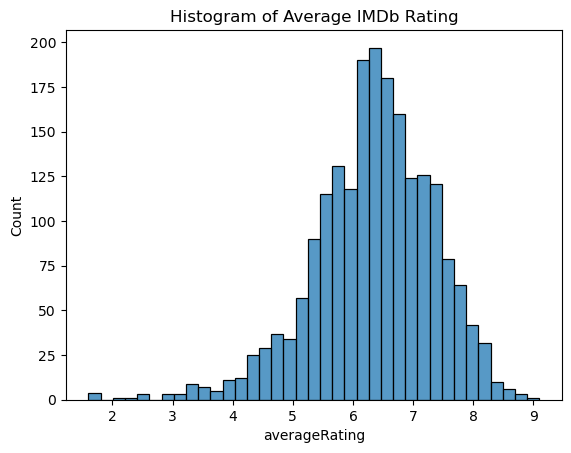

In [13]:
# Histogram of average IMDb Rating
sns.histplot(df_title_basics_ratings_office_no_duplicates, x='averageRating')
plt.title('Histogram of Average IMDb Rating')
plt.show()

C:\Users\MaxLo\AppData\Local\Temp\ipykernel_35716\979991037.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_title_basics_ratings_office_no_duplicates['Worldwide'] = df_title_basics_ratings_office_no_duplicates['Worldwide'].apply(replace_string)
C:\Users\MaxLo\AppData\Local\Temp\ipykernel_35716\979991037.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_title_basics_ratings_office_no_duplicates['Worldwide'] = df_title_basics_ratings_office_no_duplicates['Worldwide'].apply(replace_string, args=','

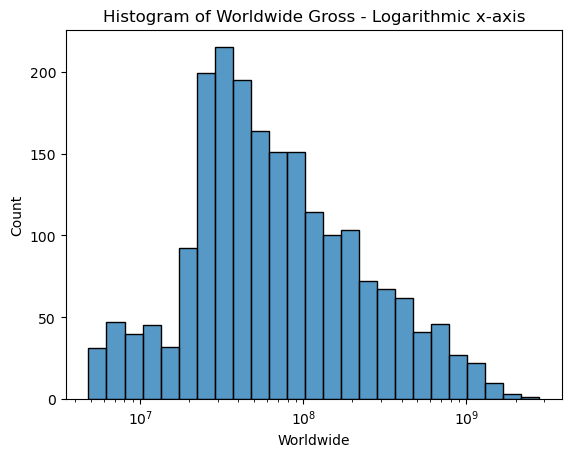

The Worldwide Gross Median is 5.55E+07 and the mean is 1.45E+08


<Axes: xlabel='Worldwide'>

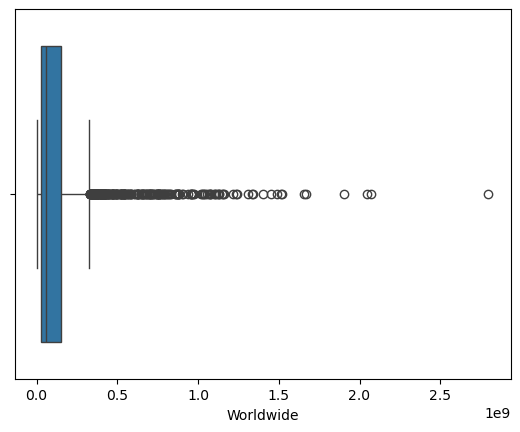

In [14]:
# Histogram of Worldwide Gross
def replace_string(s, pattern='$'):
    return str(s).replace(pattern, '')

df_title_basics_ratings_office_no_duplicates['Worldwide'] = df_title_basics_ratings_office_no_duplicates['Worldwide'].apply(replace_string)
df_title_basics_ratings_office_no_duplicates['Worldwide'] = df_title_basics_ratings_office_no_duplicates['Worldwide'].apply(replace_string, args=',')
df_title_basics_ratings_office_no_duplicates['Worldwide'] = df_title_basics_ratings_office_no_duplicates['Worldwide'].apply(int)

sns.histplot(df_title_basics_ratings_office_no_duplicates, x='Worldwide', log_scale=True)
plt.title('Histogram of Worldwide Gross - Logarithmic x-axis')
plt.show()

print(f'The Worldwide Gross Median is {df_title_basics_ratings_office_no_duplicates.Worldwide.median():.2E} and the mean is {df_title_basics_ratings_office_no_duplicates.Worldwide.mean():.2E}')

sns.boxplot(df_title_basics_ratings_office_no_duplicates, x='Worldwide')

The Pearson correlation coefficient is 0.2292269493701698, with p-value 1.3023457122344011e-25


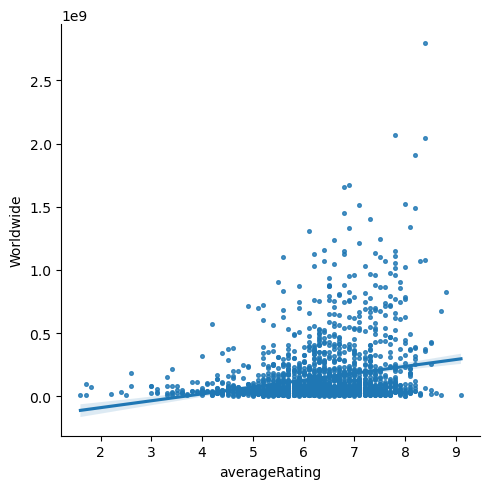

In [15]:
# Correlation between IMDb Rating and Worldwide Gross
import scipy.stats as ss

corr_Pearson = ss.pearsonr(x=df_title_basics_ratings_office_no_duplicates.averageRating, y=df_title_basics_ratings_office_no_duplicates.Worldwide)
print(f'The Pearson correlation coefficient is {corr_Pearson.statistic}, with p-value {corr_Pearson.pvalue}')

sns.lmplot(df_title_basics_ratings_office_no_duplicates, x='averageRating', y='Worldwide', scatter_kws={'s': 7})

In [16]:
# High IMDb rating (with both low and high box office)
df_title_basics_ratings_office_no_duplicates.loc[df_title_basics_ratings_office_no_duplicates.averageRating>8.5].head()

,tconst,titleType,Title,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,Worldwide,Domestic,Domestic_percent,Foreign,Foreign_percent
76,tt0816692,movie,Interstellar,Interstellar,0,2014,\N,169,"Adventure,Drama,Sci-Fi",8.7,2183892,677896797,"$188,020,017",27.70%,"$489,876,780",72.30%
292,tt10811166,movie,The Kashmir Files,The Kashmir Files,0,2022,\N,170,Drama,8.6,575313,24821898,"$1,485,000",6%,"$23,336,898",94%
720,tt1375666,movie,Inception,Inception,0,2010,\N,148,"Action,Adventure,Sci-Fi",8.8,2607668,826137188,"$292,576,195",35.40%,"$533,560,993",64.60%
1543,tt21093976,movie,National Theatre Live: Prima Facie,National Theatre Live: Prima Facie,0,2022,\N,120,Drama,9.1,2245,6589048,-,-,"$6,589,048",100%
2965,tt7466810,movie,777 Charlie,777 Charlie,0,2022,\N,164,"Adventure,Comedy,Drama",8.7,41742,7523995,-,-,"$7,523,995",100%


In [17]:
# Low Rating (low box office)
df_title_basics_ratings_office_no_duplicates.loc[df_title_basics_ratings_office_no_duplicates.averageRating<3].sample(5)

,tconst,titleType,Title,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,Worldwide,Domestic,Domestic_percent,Foreign,Foreign_percent
778,tt14121726,movie,Jeepers Creepers: Reborn,Jeepers Creepers: Reborn,0,2022,\N,88,"Horror,Mystery,Thriller",2.5,15300,5954938,"$2,033,057",34.10%,"$3,921,881",65.90%
2884,tt6910020,movie,Nothing to Lose,Nada a Perder,0,2018,\N,134,"Biography,Drama",2.4,23138,36075317,"$1,016,188",2.80%,"$35,059,129",97.20%
1199,tt1702443,movie,Justin Bieber: Never Say Never,Justin Bieber: Never Say Never,0,2011,\N,105,"Documentary,Music",1.7,76478,99036827,"$73,013,910",73.70%,"$26,022,917",26.30%
2563,tt5237980,movie,From Vegas to Macau III,Du cheng feng yun III,0,2016,\N,113,"Comedy,Drama",2.6,3360,181732879,-,-,"$181,732,879",100%
3164,tt8893870,movie,iPartment the Movie,Ai qing gong yu,0,2018,\N,117,"Adventure,Comedy,Fantasy",2.6,186,81096321,-,-,"$81,096,321",100%


In [18]:
# Low rating with high box office
df_title_basics_ratings_office_no_duplicates.loc[df_title_basics_ratings_office_no_duplicates.averageRating<6].loc[df_title_basics_ratings_office_no_duplicates.Worldwide>500000000].head()

,tconst,titleType,Title,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,Worldwide,Domestic,Domestic_percent,Foreign,Foreign_percent
32,tt0472181,movie,The Smurfs,The Smurfs,0,2011,\N,103,"Adventure,Animation,Comedy",5.4,98490,563749323,"$142,614,158",25.30%,"$421,135,165",74.70%
215,tt10370822,movie,Detective Chinatown 3,Tang ren jie tan an 3,0,2021,\N,136,"Action,Adventure,Comedy",5.6,2703,686257563,-,-,"$686,257,563",100%
641,tt1324999,movie,The Twilight Saga: Breaking Dawn - Part 1,The Twilight Saga: Breaking Dawn - Part 1,0,2011,\N,117,"Adventure,Drama,Fantasy",4.9,258303,712205856,"$281,287,133",39.50%,"$430,918,723",60.50%
642,tt1325004,movie,The Twilight Saga: Eclipse,The Twilight Saga: Eclipse,0,2010,\N,124,"Action,Adventure,Drama",5.1,265199,698491347,"$300,531,751",43%,"$397,959,596",57%
683,tt13462900,movie,The Battle at Lake Changjin,Chang jin hu,0,2021,\N,176,"Action,Drama,History",5.5,4321,902548476,"$342,411",<0.1%,"$902,206,065",100%
